In [297]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import GPy

In [171]:
num_account = 50000
losses_account_array_single = []
index_array = []
for i in range(num_account):
    f = open("../smallAccount/account_" + str(i) + ".json", "r")
    temp = json.load(f)
    if len(temp['hazard']['perils'][0]["locations"]) == 1:
        losses_account_array_single.append(temp)
        index_array.append(i)

In [172]:
x_data = []
y_data = []
periods_data = []
year_bulids_array = []
num_floor_array = []
bsum_array = []
for index, losses_account in enumerate(losses_account_array_single):
    x = losses_account["exposure"]["locations"][0]["x"]
    y = losses_account["exposure"]["locations"][0]["y"]
    year = losses_account["exposure"]["locations"][0]["yearBuilt"]
    num_floor = losses_account["exposure"]["locations"][0]["numberFloors"]
    bsum = losses_account["exposure"]["locations"][0]['bsum']
    periods_data_temp = []
    for i in range(len(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"])):
        periods_data_temp.append(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"][i]['value'])
    periods_data.append(periods_data_temp)
    x_data.append(x)
    y_data.append(y)
    year_bulids_array.append(year)
    num_floor_array.append(num_floor)
    bsum_array.append(bsum)
periods_data = np.array(periods_data, dtype=np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
year_bulids_array = np.array(year_bulids_array, dtype=np.float32)
num_floor_array = np.array(num_floor_array, dtype=np.float32)
bsum_array = np.array(bsum_array, dtype=np.float32)

In [233]:
AAL_GU_array = []
EP_GU_array = []
for index in index_array:
    f = open("../results/losses_Account_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp = l[1].split(",")
    AAL_GU_array.append(float(temp[1]))
    EP_GU_array.append(np.array([temp[i+3] for i in range(10)], dtype=np.float32))
AAL_GU_array = np.array(AAL_GU_array, dtype=np.float32)
EP_GU_array = np.array(EP_GU_array, dtype=np.float32)

In [256]:
scale =np.array([10,25,50,100,250,500,1000,2000,5000,10000], dtype=np.float32)
np.sum(EP_GU_array[0]/scale)

4696.39

In [269]:
sum_loss = 0
for i in range(len(scale)-1):
    sum_loss += (EP_GU_array[1][i]+EP_GU_array[1][i+1])/2*(1/scale[i]-1/scale[i+1])

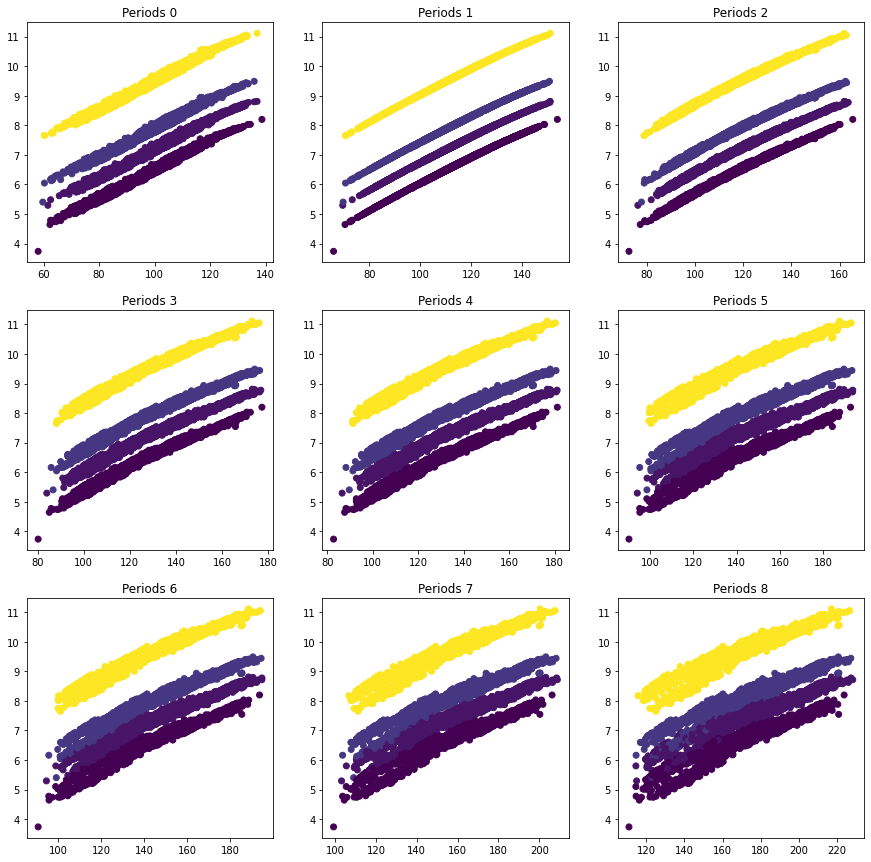

In [234]:
fig , axs= plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i//3, i%3].scatter(periods_data[:, i], np.log(AAL_GU_array), c = bsum_array)
    axs[i//3, i%3].set_title("Periods " + str(i))

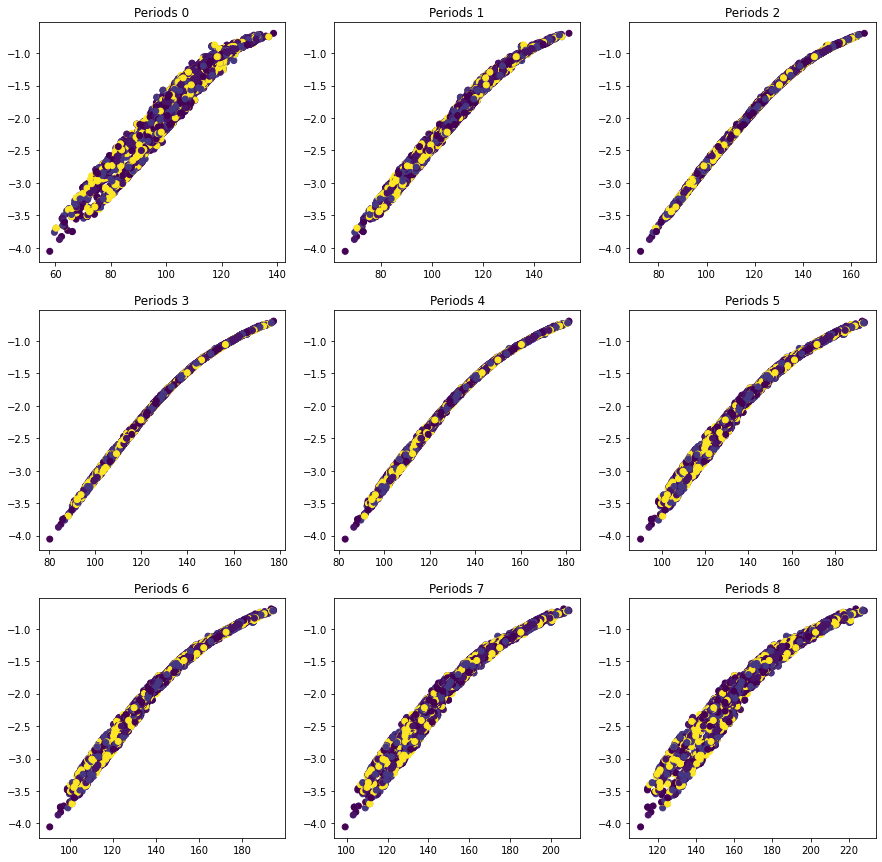

In [354]:
fig , axs= plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i//3, i%3].scatter(periods_data[:, i], np.log(EP_GU_array[:,6]/bsum_array), c = bsum_array)
    axs[i//3, i%3].set_title("Periods " + str(i))

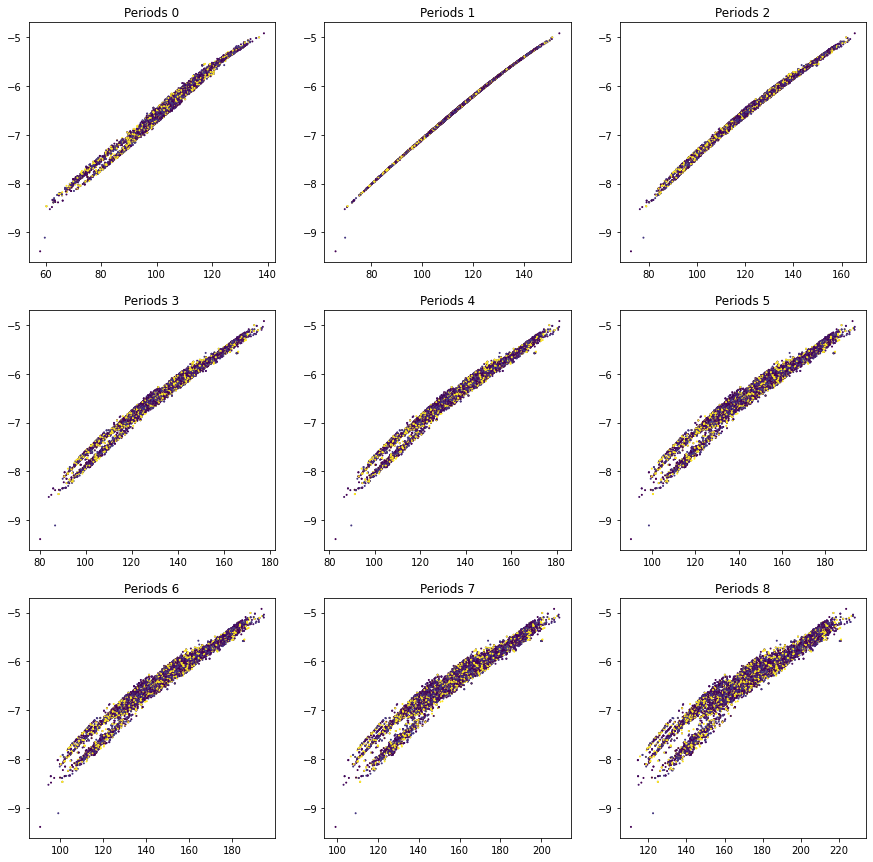

In [316]:
fig , axs= plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i//3, i%3].scatter(periods_data[:, i], np.log(AAL_GU_array/bsum_array), c = bsum_array, s = 1)    
    axs[i//3, i%3].set_title("Periods " + str(i))

In [379]:
#1次元のガウス過程回帰
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
x = periods_data[:, 0]
y = np.log(AAL_GU_array/bsum_array)
x_train = x[:1000]
y_train = y[:1000]
m = GPy.models.GPRegression(x_train[:, None], y_train[:, None], kernel)
m.optimize(messages=True)

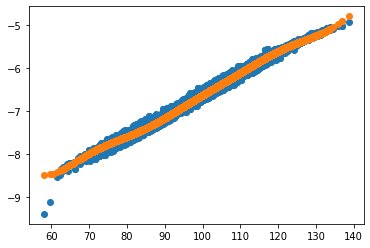

In [380]:
y_test = m.predict(x[1000:, None])[0]
plt.scatter(x[1000:], y[1000:])
plt.scatter(x[1000:], y_test)

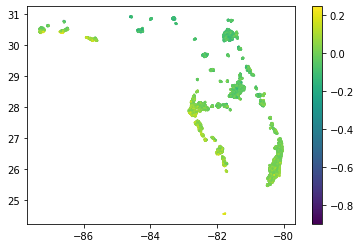

In [361]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.array(y[1000:, None] - y_test, dtype=np.float32), s = 1)
#カラースケールの設定
plt.colorbar()


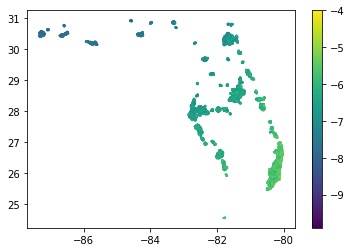

In [365]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.array(y_test, dtype=np.float32), s = 1,vmin=-4, vmax=-9)
#カラースケールの設定(-4から-9)
plt.colorbar()  

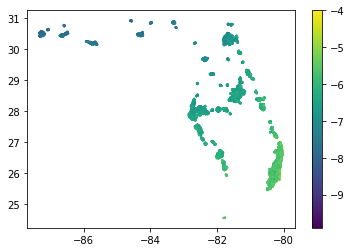

In [366]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.array(np.log(AAL_GU_array[1000:, None]/bsum_array[1000:, None]), dtype=np.float32), s = 1,vmin=-4, vmax=-9)
plt.colorbar()

In [381]:
# relative error
np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None] - np.exp(y_test))/np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None])

9.350532077544201e-07

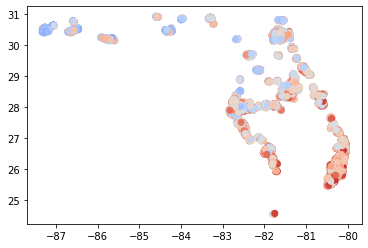

In [230]:
plt.scatter(x_data, y_data, c=np.log(AAL_GU_array), cmap='coolwarm')

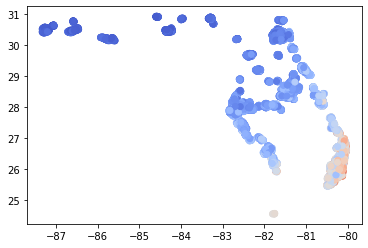

In [272]:
plt.scatter(x_data, y_data, c=AAL_GU_array/bsum_array, cmap='coolwarm')

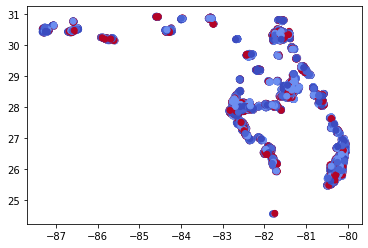

In [292]:
plt.scatter(x_data, y_data, c=bsum_array, cmap='coolwarm')

In [ ]:
#xが-81 < -80, yが25 < 27.5のものを抽出
bsum_limit = []
AAL_GU_limit = []
category_bsum = np.array([500000.0, 1000000.0, 2000000.0, 10000000.0])
category_cnt = np.zeros(4)
category_mean = np.zeros(4)
for i in range(len(x_data)):
    if x_data[i] > -81 and x_data[i] < -80 and y_data[i] > 25 and y_data[i] < 27.5:
        bsum_limit.append(bsum_array[i])
        AAL_GU_limit.append(AAL_GU_array[i])
        for j in range(4):
            if bsum_array[i] == category_bsum[j]:
                category_cnt[j] += 1
                category_mean[j] += AAL_GU_array[i]
category_mean = category_mean / category_cnt
plt.plot(category_bsum, category_mean, marker='o') 
        

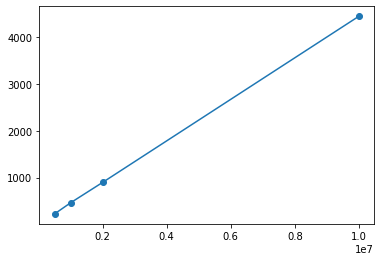

In [295]:
#xが-81 < -80, yが25 < 27.5のものを抽出
bsum_limit = []
AAL_GU_limit = []
category_bsum = np.array([500000.0, 1000000.0, 2000000.0, 10000000.0])
category_cnt = np.zeros(4)
category_mean = np.zeros(4)
for i in range(len(x_data)):
    if x_data[i] > -88 and x_data[i] < -86 and y_data[i] > 30 and y_data[i] < 31:
        bsum_limit.append(bsum_array[i])
        AAL_GU_limit.append(AAL_GU_array[i])
        for j in range(4):
            if bsum_array[i] == category_bsum[j]:
                category_cnt[j] += 1
                category_mean[j] += AAL_GU_array[i]
category_mean = category_mean / category_cnt
plt.plot(category_bsum, category_mean, marker='o') 
        

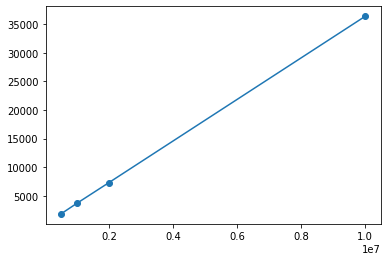

In [296]:
#xが-81 < -80, yが25 < 27.5のものを抽出
bsum_limit = []
AAL_GU_limit = []
category_bsum = np.array([500000.0, 1000000.0, 2000000.0, 10000000.0])
category_cnt = np.zeros(4)
category_mean = np.zeros(4)
for i in range(len(x_data)):
    if x_data[i] > -81 and x_data[i] < -80 and y_data[i] > 25 and y_data[i] < 27.5:
        bsum_limit.append(bsum_array[i])
        AAL_GU_limit.append(AAL_GU_array[i])
        for j in range(4):
            if bsum_array[i] == category_bsum[j]:
                category_cnt[j] += 1
                category_mean[j] += AAL_GU_array[i]
category_mean = category_mean / category_cnt
plt.plot(category_bsum, category_mean, marker='o') 
        

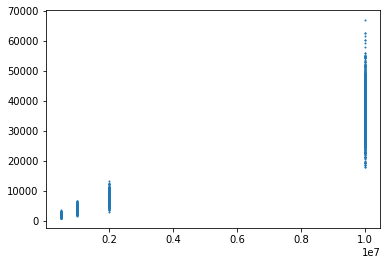

In [277]:
plt.plot(bsum_limit, AAL_GU_limit, 'o', markersize=1)

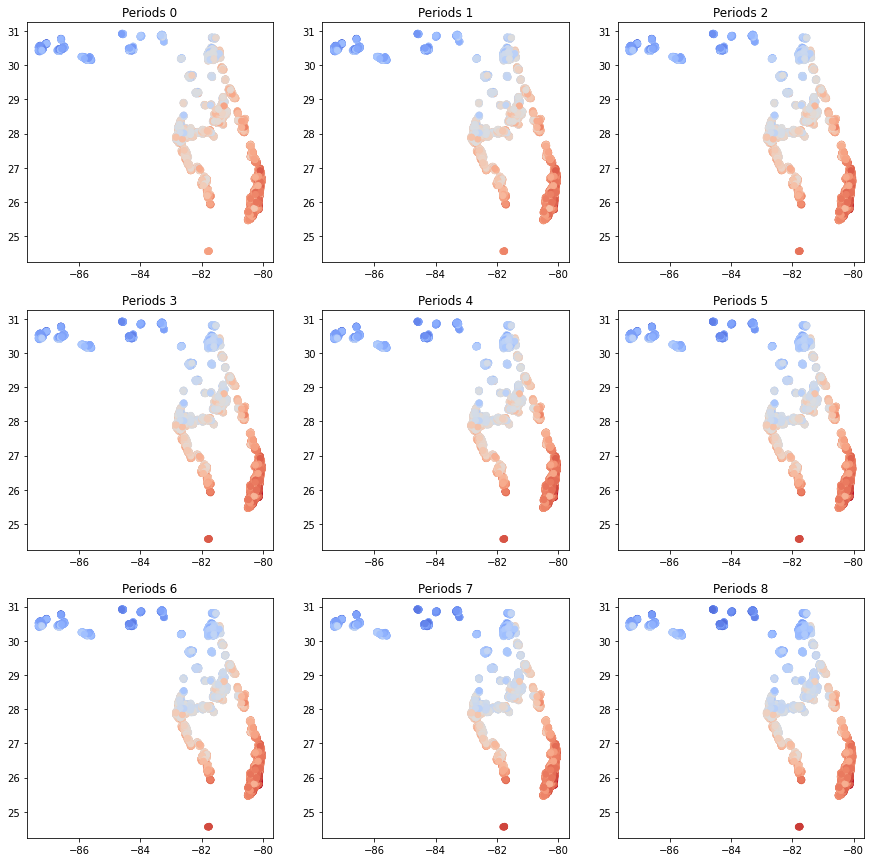

In [232]:
fig , axs= plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i//3, i%3].scatter(x_data, y_data, c = periods_data[:, i], cmap='coolwarm')
    axs[i//3, i%3].set_title("Periods " + str(i))

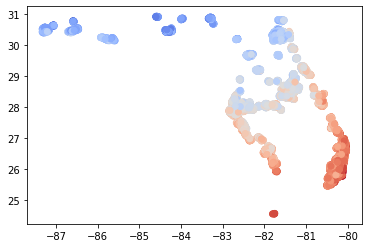

In [143]:
plt.scatter(x_data, y_data, c=periods_data[:, 5], cmap='coolwarm')

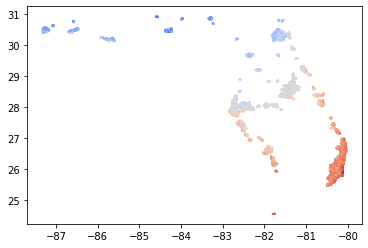

In [312]:
plt.scatter(x_data, y_data, c=periods_data[:, 5], cmap='coolwarm', s=0.5)

In [375]:
kernel = GPy.kern.RBF(2)
X_train = np.array([x_data, y_data]).T
y_train = np.log(AAL_GU_array/bsum_array)
X_train = X_train[:1000]
y_train = y_train[:1000]
model = GPy.models.GPRegression(np.array(X_train), np.array(y_train)[:,None], kernel)
model.optimize(messages=False)
# 1000データの学習に8分かかる

In [376]:
X_test = np.array([x_data, y_data]).T
X_test = X_test[1000:]
y_test = GPy.models.GPRegression.predict(model, X_test)[0]
y_test = np.exp(y_test)


In [378]:
np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None] - y_test)/np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None])

0.20837137183963259

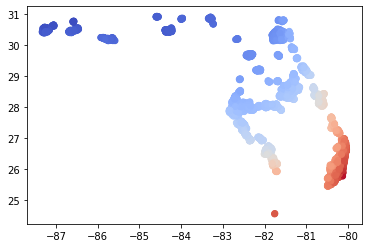

In [309]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm')

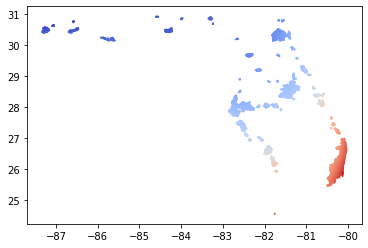

In [313]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', s=0.5)